<a href="https://colab.research.google.com/github/jkjh23/BusanAIDeveloperCourse_AI_FinalProject/blob/main/Preliminary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.externals import joblib

import warnings 
from tqdm import tqdm_notebook, tqdm

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


- [GPU 사용해서 SVM 돌리기](https://www.kaggle.com/c/2019-ml-finalproject/discussion/119011)

In [19]:
df = pd.read_csv('/content/drive/My Drive/2020_AI_Contest/Data/train/train.tsv', sep='\t', names=['file_name', 'plant_label', 'disease_label'])
df

,file_name,plant_label,disease_label
0,3_5_1123.jpg,3,5
1,3_20_1048.jpg,3,20
2,4_2_401.jpg,4,2
3,4_7_740.jpg,4,7
4,4_11_93.jpg,4,11
...,...,...,...
15995,13_15_1600.jpg,13,15
15996,13_16_1570.jpg,13,16
15997,13_17_986.jpg,13,17
15998,13_18_4980.jpg,13,18


In [20]:
warnings.filterwarnings(action='ignore')
df['class_label'] = 'Nan'

comb = [(df.plant_label[i], df.disease_label[i]) for i in range(0,df.shape[0])]
combUnique = []
for v in comb:
    if v not in combUnique:
        combUnique.append(v)

for i in range(0,df.shape[0]) :
    df['class_label'][i] = combUnique.index((df.plant_label[i], df.disease_label[i]))

df = df.loc[:, ['file_name', 'class_label']]
df = df 

df

,file_name,class_label
0,3_5_1123.jpg,0
1,3_20_1048.jpg,1
2,4_2_401.jpg,2
3,4_7_740.jpg,3
4,4_11_93.jpg,4
...,...,...
15995,13_15_1600.jpg,15
15996,13_16_1570.jpg,16
15997,13_17_986.jpg,17
15998,13_18_4980.jpg,18


## 이미지 확인

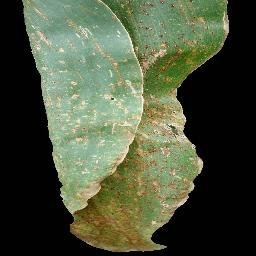

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img

In [ ]:
type(img), np.array(img).shape, img.size

(PIL.JpegImagePlugin.JpegImageFile, (256, 256, 3), (256, 256))

# SVM

## 전체 데이터 - 컬러 - 학습

### 100개 단위, rbf

In [ ]:
model = SVC()

for muldf in tqdm_notebook(range(0,160)) :
  num = 100 * muldf
  dfPart = df[num:num+100]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)

In [ ]:
joblib.dump(model, 'entire_color.pkl') 

['entire_color.pkl']

In [ ]:
# 드라이브에 저장
# joblib.dump(model, '/content/drive/My Drive/2020_AI_Contest/entire_color.pkl') 

['/content/drive/My Drive/2020_AI_Contest/entire_color.pkl']

In [ ]:
model = joblib.load('entire_color.pkl') 

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

df = df[4300:5300].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((df.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, df.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + df.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((df.shape[0],))
for i in range(0, df.shape[0]) :
    y[i] = df['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

In [ ]:
pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

# 0.1268319997053765 => 결과가 쓰레기다

0.1268319997053765

### 200개 단위, linear

In [ ]:
model = SVC(kernel='linear')
 
val1 = 200
val2 = int(df.shape[0] / val1)

for muldf in tqdm_notebook(range(0,val2)) :
  num = val1 * muldf
  dfPart = df[num:num+val1]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)

In [ ]:
joblib.dump(model, '/content/drive/My Drive/2020_AI_Contest/entire_color_200_linear.pkl')

['/content/drive/My Drive/2020_AI_Contest/entire_color_200_linear.pkl']

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
df = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((df.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, df.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + df.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((df.shape[0],))
for i in range(0, df.shape[0]) :
    y[i] = df['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.4049340323413346

In [18]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
df = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((df.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, df.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + df.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((df.shape[0],))
for i in range(0, df.shape[0]) :
    y[i] = df['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.3808181048525476

In [21]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
df = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((df.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, df.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + df.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((df.shape[0],))
for i in range(0, df.shape[0]) :
    y[i] = df['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

# 0.38 ~ 0.40 사이로 나옴

0.38385052088360944